# Chapter 5. **RAG Pipeline for Automatic Text Classification**

In this chapter, we will explore an alternative approach to text
classification building a simple retrieval-augmented generation (RAG)
system. This chapter will cover: \* Building a **knowledge base** using
official NACE category descriptions. \* **Retrieving** the `top_k`
relevant categories based on a **natural language query**. \* Using a
**large language model** (LLM) to make the final classification.

<figure>
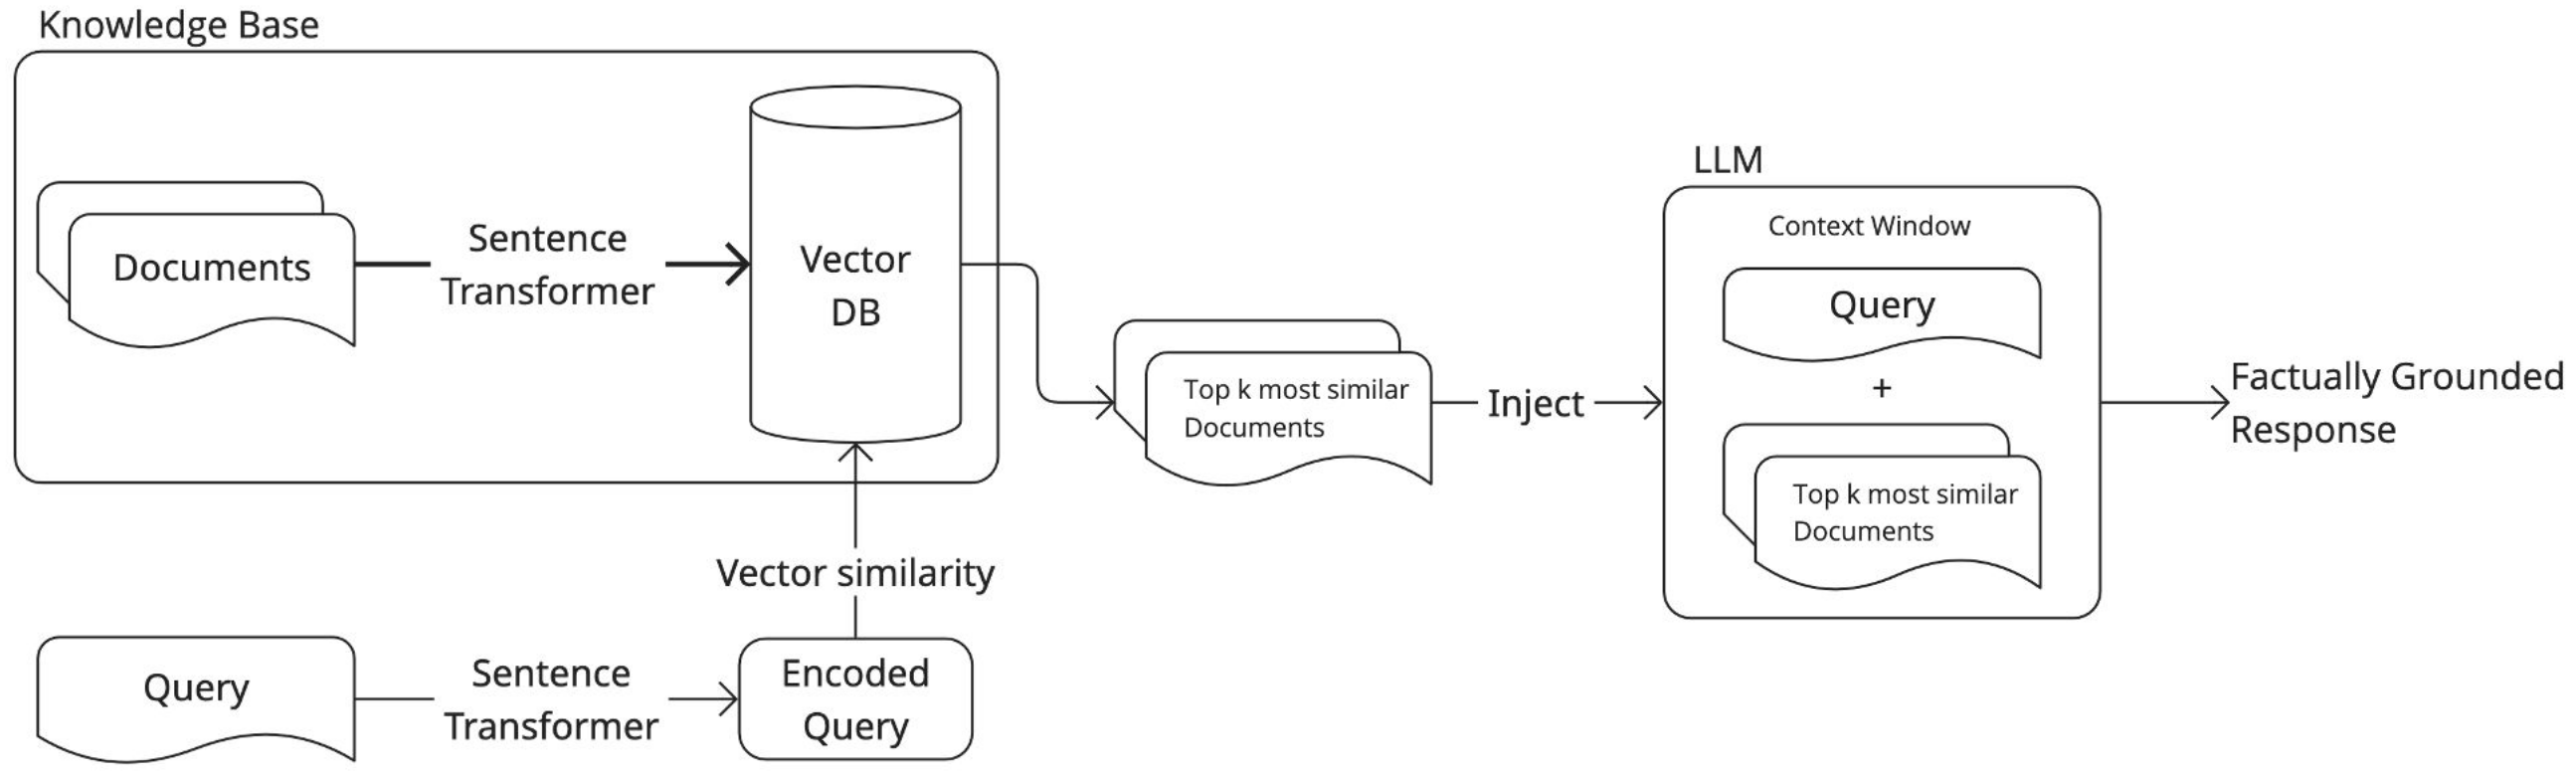
<figcaption aria-hidden="true">RAG System Scheme</figcaption>
</figure>

In [ ]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from transformers import pipeline

------------------------------------------------------------------------

## Phase 1 - Knowledge Base Creation

The first step in any RAG system is to build a **knowledge base**. \> In
the context of retrieval-augmented generation, a knowledge base is a
structured **collection of external information** (e.g., documents,
descriptions…) that can be **searched and retrieved from**. This is
usually employed to ground LLM responses into factual information
instead on relying solely on the model’s internal knowledge, or to
augment the model with knowledge that was not available in the training
set.

In order to build a knowledge base we need to: 1. Define what documents
to store and how to structure them. 2. Embed the selected texts using a
sentence-level embedding model (`SentenceTransformer`). 3. Store the
embeddings in memory or in a vector database.

### Defining and structuring documents

In our case, the knowledge base will be comprised by the NACE codes at
the division level (2-digit). Therefore, the first step is to load the
file containing all NACE codes and pre-process it.

In [ ]:
nace_df = pd.read_excel("data/NACE_Rev2.1_Structure_Explanatory_Notes_EN.xlsx")

Now, we can isolate the NACE divisions.

In [ ]:
nace_division_df = nace_df[nace_df["ID"].str.len() == 2].reset_index(drop=True)

nace_division_df.head()

As we can see, the dataset has multiple textual columns, like titles and
descriptions (*Includes*, etc.). \> In general, **the more context** we
give to the embedding model **the better**, as long as the final text to
embed doesn’t get too long.

A simple way to exploit the textual information present in the NACE
dataset, is to include different textual features into a **structured
template**, which we can call **descriptor**. In this setting, each NACE
division will be associated to one descriptor, made of its title and
further information present in the dataset.

In [ ]:
codes = nace_division_df["ID"].tolist()
titles = nace_division_df["NAME"].tolist()
descriptions = nace_division_df["Includes"].tolist()

descriptor_template = "{title}.\n{description}"

descriptors = []
for title, description in zip(titles, descriptions):
    descriptors.append(
        descriptor_template.format(title=title.upper(), description=description)
    )

Let’s print one descriptor.

In [ ]:
print(descriptors[5])

These descriptors will be the actual text that will be embedded to
create the knowledge base.

### Embed the descriptors

Now that we built a descriptor for each of the 80+ NACE divisions, we
need to embed them using a **sentence-level embedding model**. There are
plenty of such models on Hugging Face. We can load them using the
`SentenceTransformer` class from the `sentence_transformers` library.

For this example, we will use the lightweight **multilingual**
`paraphrase-multilingual-MiniLM-L12-v2` model from the S-BERT family.
Since we need to match descriptions in French with NACE codes in
English, it is important that our model can handle multiple languages.

In [ ]:
MODEL_ID: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

model = SentenceTransformer(MODEL_ID)

After loading the model, we can embed the descriptors. Each descriptor
will be embedded into a **384-dimensional embedding vector**.

In [ ]:
embeddings = model.encode(descriptors, convert_to_tensor=True)

Since we only have 87 NACE divisions (and therefore 87 vectors), for the
purpose of this tutorial we can keep the embeddings in memory without
relying on vector databases.

------------------------------------------------------------------------

## Phase 2 - Searching the Knowledge Base

This phase consists in developing a method to search the knowledge base
via semantic similarity. \> When searching a knowledge base, a natural
language query is embedded **via the same model used to create the
knowledge base** and a **distance metric** is computed to evaluate the
**similarity** between the query and the documents in the knowledge
base.

The most popular distance metric used to retrieve elements from a
knowledge base is **cosine similarity**, defined as:
$$\cos (\theta)=\frac{\mathbf{A}\cdot \mathbf{B}}{||\mathbf{A}||||\mathbf{B}||}$$
where $\theta$ is the angle between the embedding vectors $\mathbf{A}$
and $\mathbf{B}$.

Now we can finally define a function that searches the knowledge base
given a natural language query and retrieves the `top_k` most similar
results.

In [ ]:
def search_base(
    query: str,
    base: torch.Tensor,
    embedding_model: SentenceTransformer,
    top_k: int = 5
):
    query_embedding = embedding_model.encode(query, convert_to_tensor=True)
    cos_scores = torch.nn.functional.cosine_similarity(base, query_embedding)
    top_results = torch.topk(cos_scores, k=top_k)

    return top_results

Let’s test the function with a sample query. We get both `values`
(similarity scores) and `indices` as a result. In order to extract the
**corresponding NACE divisions**, we can use the indices to filter the
NACE dataframe.

In [ ]:
sample_query = "Attività di estrazione mineraria."

top_results = search_base(sample_query, embeddings, model, top_k=5)

for i, sim in zip(top_results.indices, top_results.values):
    code = nace_division_df.iloc[int(i)]["ID"]
    title = nace_division_df.iloc[int(i)]["NAME"]
    print(f"{code}: {title}\nSimilarity: {sim:.3f}\n")

In theory, we could stop here and just pick the first result as our
classification guess. However, a more robust approach involves an LLM
judge to pick between the candidates.

------------------------------------------------------------------------

## Phase 3 - Final LLM Classification

This final stage comprises a generative large language model to pick an
option between the retrieved candidate codes. First, we load the LLM via
the Hugging Face `pipeline` wrapper.

In [ ]:
LLM_ID: str = "unsloth/Llama-3.2-3B-Instruct"

pipe = pipeline(
    "text-generation",
    model=LLM_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

### System Prompt and Instructions

We need to define a **system prompt**, i.e., textual guidelines that
will help the LLM follow our instructions, and the actual **prompt
template** to parse the LLM input.

In [ ]:
SYSTEM_PROMPT: str = """You are an economic activity classifier.

Based on a description, return ONLY the most fitting candidate without any additional text."""

PROMPT_TEMPLATE: str = """DESCRIPTION: "{query}"

CANDIDATES:\n{candidates}"""

### Parsing the Input

We need to extract the **list of candidates** using semantic-based
similarity and parse it to make it understandable for the LLM.

In [ ]:
sample_query = "Mining activities"

top_results = search_base(sample_query, embeddings, model, top_k=5)

candidates_list = []
for i, sim in zip(top_results.indices, top_results.values):
    code = nace_division_df.iloc[int(i)]["ID"]
    title = nace_division_df.iloc[int(i)]["NAME"]
    candidates_list.append(f"{code} - {title}")

candidates = "\n".join(candidates_list)

Let’s print the parsed prompt to visualize it.

In [ ]:
parsed_prompt = PROMPT_TEMPLATE.format(query=sample_query, candidates=candidates)

print(parsed_prompt)

### Full RAG System

Now, we can test the **full RAG system** to classify the economic
activity given a natural language query.

In [ ]:
messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": parsed_prompt},
]

outputs = pipe(
    messages,
    max_new_tokens=32,
    pad_token_id=pipe.tokenizer.eos_token_id
)

llm_out = outputs[0]["generated_text"][-1]["content"]
print(llm_out)

------------------------------------------------------------------------

## Interactive Demo

Finally, we can create a small **interactive demo** for our RAG system.
First, we need to create a `rag` function to perform the whole pipeline.

In [ ]:
def rag(
    query: str,
    embeddings: torch.Tensor,
    embedding_model: SentenceTransformer,
    llm: pipeline,
    system_prompt: str,
    prompt_template: str,
    nace_df: pd.DataFrame,
    top_k: int = 5
):

    top_results = search_base(query, embeddings, embedding_model, top_k=5)

    candidates_list = []
    for i, sim in zip(top_results.indices, top_results.values):
        code = nace_df.iloc[int(i)]["ID"]
        title = nace_df.iloc[int(i)]["NAME"]
        candidates_list.append(f"{code} - {title}")

    candidates = "\n".join(candidates_list)

    parsed_prompt = PROMPT_TEMPLATE.format(query=query, candidates=candidates)

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": parsed_prompt},
    ]

    outputs = pipe(
        messages,
        max_new_tokens=16,
        pad_token_id=pipe.tokenizer.eos_token_id
    )

    return outputs[0]["generated_text"][-1]["content"]

Now we can run the demo.

In [ ]:
query = input("Entry a query ('EXIT' to stop): ")

while query != "EXIT":
    output = rag(query, embeddings, model, pipe, SYSTEM_PROMPT, PROMPT_TEMPLATE, nace_division_df)
    print(f"RESULT: {output}")
    print("")
    query = input("Entry a query ('EXIT' to stop): ")